# Sacroiliitis

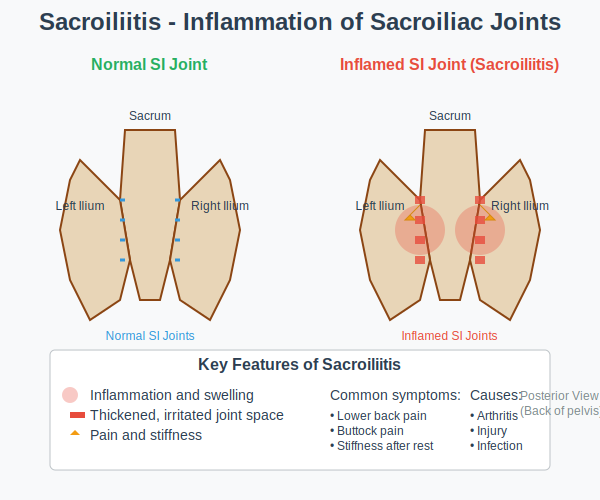

In [2]:
from IPython.display import SVG, display

display(SVG(filename='sacroiliitis.svg'))


## Upload this file to S3 if necessary

In [10]:
import os

def get_notebook_filename():
    """
    Prompts user for the notebook filename if not already defined in env var.
    Validates that the file exists.
    Sets an environment variable JUPYTER_FILE_NAME upon success.
    """

    # Check if environment variable already exists
    nb_env_var = os.environ.get("JUPYTER_FILE_NAME")
    if nb_env_var:
        print(f"Notebook filename already set: {nb_env_var}")
        return nb_env_var

    while True:
        name = input("Enter notebook name (without .ipynb), or /quit to exit: ").strip()

        # Allow user to exit
        if name.lower() == "/quit":
            print("Operation cancelled by user.")
            return None

        # Provide default if blank
        if not name:
            name = "notebook"

        # Append .ipynb if not provided
        if not name.endswith(".ipynb"):
            name += ".ipynb"

        # Check if the file exists
        if os.path.isfile(name):
            print(f"Notebook file found: {name}")
            os.environ["JUPYTER_FILE_NAME"] = name
            return name
        else:
            print(f"ERROR: File '{name}' does not exist. Please try again or type /quit.")

local_file = get_notebook_filename()
print (f"local_file = {local_file}")
       


Notebook filename already set: svg.ipynb
local_file = svg.ipynb


In [16]:
import boto3
import hashlib

#local_file = "svg.ipynb"

def should_upload_file(bucket, s3_key, local_file_path):
    """
    Check if local file differs from S3 file using ETag comparison
    Returns True if upload is needed, False if files are the same
    """
    
    print(f"🔍 Checking if '{local_file_path}' needs to be uploaded...")
    
    s3_client = boto3.client('s3')
    
    # Step 1: Check if file exists in S3
    try:
        s3_response = s3_client.head_object(Bucket=bucket, Key=s3_key)
        s3_etag = s3_response['ETag'].strip('"')  # Remove quotes
        s3_size = s3_response['ContentLength']
        
        print(f"✅ File exists in S3:")
        print(f"   🏷️  S3 ETag: {s3_etag}")
        print(f"   📏 S3 Size: {s3_size:,} bytes")
        
    except Exception as e:
        if "404" in str(e) or "Not Found" in str(e):
            print("📭 File doesn't exist in S3 - upload needed")
            return True
        else:
            print(f"❌ Error checking S3: {e}")
            return True  # Upload on error to be safe
    
    # Step 2: Calculate local file MD5
    try:
        with open(local_file_path, 'rb') as f:
            file_content = f.read()
            local_md5 = hashlib.md5(file_content).hexdigest()
            local_size = len(file_content)
        
        print(f"📄 Local file:")
        print(f"   🏷️  Local MD5: {local_md5}")
        print(f"   📏 Local Size: {local_size:,} bytes")
        
    except Exception as e:
        print(f"❌ Error reading local file: {e}")
        return True  # Upload on error
    
    # Step 3: Compare
    if local_md5 == s3_etag and local_size == s3_size:
        print("✅ Files are IDENTICAL - no upload needed")
        return False
    else:
        print("🔄 Files are DIFFERENT - upload needed")
        print(f"   MD5 match: {local_md5 == s3_etag}")
        print(f"   Size match: {local_size == s3_size}")
        return True

# Example usage
bucket = "cpbucket-investigate-001"
#local_file = "svg.ipynb"
s3_key = local_file  # Use same name in S3

upload_needed = should_upload_file(bucket, s3_key, local_file)

if upload_needed:
    print(f"\n🚀 Uploading {local_file}...")
    
    s3 = boto3.resource('s3')
    with open(local_file, 'rb') as data:
        s3.Bucket(bucket).put_object(Key=s3_key, Body=data)
    
    print("✅ Upload complete!")
else:
    print(f"\n⏭️  Skipping upload - {local_file} is already up to date")

🔍 Checking if 'svg.ipynb' needs to be uploaded...
✅ File exists in S3:
   🏷️  S3 ETag: e9851abd1d7e2b0fd888032b3efb3ae9
   📏 S3 Size: 16,507 bytes
📄 Local file:
   🏷️  Local MD5: e9851abd1d7e2b0fd888032b3efb3ae9
   📏 Local Size: 16,507 bytes
✅ Files are IDENTICAL - no upload needed

⏭️  Skipping upload - svg.ipynb is already up to date
